In [1]:
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from mpl_toolkits.basemap import Basemap

import numpy as np
import pandas as pd

# Loading

In [2]:
TRAIN_PATH = "data/download/train.csv"
TEST_PATH = "data/download/test.csv"

PROC_DIR = "data/processed_data"

In [3]:
# number of rows of train
#!wc -l {TRAIN_PATH}

with open(TRAIN_PATH) as file:
    n_rows = len(file.readlines())

print (f'The number of rows in train.csv: {n_rows}')

The number of rows in train.csv: 55423857


In [4]:
# number of rows of test
#!wc -l {TEST_PATH}

with open(TEST_PATH) as file:
    n_rows = len(file.readlines())

print (f'The number of rows in test.csv: {n_rows}')

The number of rows in test.csv: 9915


In [5]:
# let's read the first few rows
train_df = pd.read_csv(TRAIN_PATH, nrows=5)
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
key                  5 non-null object
fare_amount          5 non-null float64
pickup_datetime      5 non-null object
pickup_longitude     5 non-null float64
pickup_latitude      5 non-null float64
dropoff_longitude    5 non-null float64
dropoff_latitude     5 non-null float64
passenger_count      5 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 400.0+ bytes


In [7]:
pd.to_datetime(train_df["key"])

0   2009-06-15 17:26:21.000000100
1   2010-01-05 16:52:16.000000200
2   2011-08-18 00:35:00.000000490
3   2012-04-21 04:30:42.000000100
4   2010-03-09 07:51:00.000000135
Name: key, dtype: datetime64[ns]

In [8]:
pd.to_datetime(train_df["pickup_datetime"])

0   2009-06-15 17:26:21+00:00
1   2010-01-05 16:52:16+00:00
2   2011-08-18 00:35:00+00:00
3   2012-04-21 04:30:42+00:00
4   2010-03-09 07:51:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

Cột `key` và cột `pickup_datetime` đều có cùng timestamp. Trong đó `pickup_datetime` có độ chính xác đến hàng giây, còn `key` có độ chính xác đến hàng nano giây. `key` chỉ dùng để phân biệt các dòng với nhau, do đó nó không quan trọng trong việc phân tích dữ liệu và xây dựng mô hình. Ta sẽ drop cột `key` này ra khỏi tập train. `key` vẫn được dùng trong tập test để submit file lên Kaggle.

Tập `train.csv` có số lượng dòng khá lớn (khoảng 55 triệu dòng). Do đó, việc đọc hết dữ liệu trong train.csv tốn rất nhiều thời gian. Để việc đọc data được nhanh, ta sẽ giảm size của chúng lại. Link tham khảo trên Kaggle https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows.

In [9]:
def load_nyc_taxi_fare(path, col_types, chunksize=None, 
                       datetime_format="%Y-%m-%d %H:%M:%S UTC",
                       utc=False,
                       convert_to_timezone=None):
    chunk_iter = pd.read_csv(path, usecols=col_types.keys(), dtype=col_types, chunksize=chunksize)
    
    if chunksize is None:
        chunk_iter["pickup_datetime"] = pd.to_datetime(chunk_iter["pickup_datetime"], 
                                                       utc=utc, format=datetime_format)
        # convert to different timezone
        if convert_to_timezone is not None:
            chunk_iter["pickup_datetime"] = chunk_iter["pickup_datetime"].dt.tz_convert(convert_to_timezone)
        return chunk_iter
    
    df_list = []
    # use tqdm to monitor progress
    # It would take extremely long time if format were not used.
    for df_chunk in tqdm(chunk_iter):
        df_chunk["pickup_datetime"] = pd.to_datetime(df_chunk["pickup_datetime"], 
                                                     utc=utc, format=datetime_format)
        # convert to different timezone
        if convert_to_timezone is not None:
            df_chunk["pickup_datetime"] = df_chunk["pickup_datetime"].dt.tz_convert(convert_to_timezone)
        
        df_list.append(df_chunk)
        
    return pd.concat(df_list)

In [10]:
train_types = {"fare_amount": "float32",
              "pickup_datetime": "str", 
              "pickup_longitude": "float32",
              "pickup_latitude": "float32",
              "dropoff_longitude": "float32",
              "dropoff_latitude": "float32",
              "passenger_count": "uint8"}
train_df = load_nyc_taxi_fare(TRAIN_PATH, train_types, chunksize=5_000_000, utc=True,
                              convert_to_timezone='US/Eastern')
train_df.head()

12it [05:30, 21.87s/it]


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 13:26:21-04:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 11:52:16-05:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-17 20:35:00-04:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 00:30:42-04:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 02:51:00-05:00,-73.968094,40.768009,-73.956657,40.783764,1


In [11]:
train_df.shape

(55423856, 7)

In [12]:
train_df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, US/Eastern]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns, US/Eastern](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [13]:
test_types = train_types.copy()
test_types.pop("fare_amount")
test_types["key"] = "str"

test_df = load_nyc_taxi_fare(TEST_PATH, test_types, utc=True, convert_to_timezone='US/Eastern')
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 08:08:24-05:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 08:08:24-05:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 07:53:44-04:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 16:12:12-05:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 16:12:12-05:00,-73.966049,40.789776,-73.988564,40.744427,1


# Cleaning and EDA

In [14]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,8.077921e+00,-3.875290e+01,1.937328e+01,-3.875261e+01,1.937341e+01,1.685380e+00
std,2.055127e+01,2.556202e+01,1.414234e+01,2.553839e+01,1.412191e+01,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


Is there any Null?

In [15]:
train_df.isnull().sum()

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

Do số dòng chứa giá trị null rất ít so với tổng số dòng của dữ liệu nên ta quyết định drop chúng.

In [16]:
print("shape before dropping:", train_df.shape)
train_df = train_df.dropna(axis=0, how="any")
print("shape after dropping:", train_df.shape)

shape before dropping: (55423856, 7)
shape after dropping: (55423480, 7)


## Cleaning up `fare_amount`

Nhìn vào 'train_df.describe( )' ta thấy cột 'fare_amount' có chứa giá trị âm. Điều này là vô lý nên ta sẽ drop chúng ra khỏi bảng dữ liệu

In [17]:
print("Number of negative values of fare_amount: %d " % (train_df["fare_amount"] < 0).sum())

Number of negative values of fare_amount: 2454 


In [18]:
print("Shape before dropping:", train_df.shape)
train_df = train_df[train_df["fare_amount"] >= 0]
print("Shape after dropping:", train_df.shape)

Shape before dropping: (55423480, 7)
Shape after dropping: (55421026, 7)


Đồng thời, cột `fare_amount` cũng chứa nhiều giá trị rất lớn. Ta sẽ kiểm tra để loại các outliers.

Text(0.5, 1.0, 'data with fare_amount < 200')

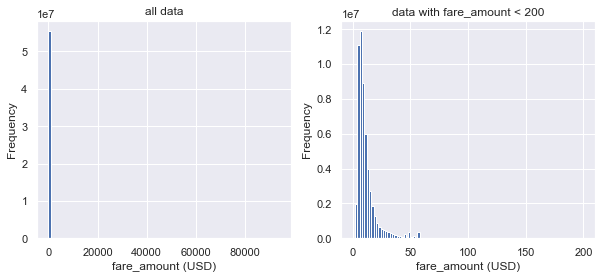

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
train_df["fare_amount"].plot(kind="hist", ax=ax[0], bins=100)
ax[0].set_xlabel("fare_amount (USD)")
ax[0].set_title("all data")

train_df.loc[train_df["fare_amount"] < 200, "fare_amount"].plot(kind="hist", bins=100, ax=ax[1])
ax[1].set_xlabel("fare_amount (USD)")
ax[1].set_title("data with fare_amount < 200")

In [20]:
for fare in [100, 200, 500, 1000, 5000, 10000]:
    print("Number of rows with fare_amount greater than $%d is %d" %(fare, (train_df["fare_amount"] > fare).sum()))

Number of rows with fare_amount greater than $100 is 20875
Number of rows with fare_amount greater than $200 is 1654
Number of rows with fare_amount greater than $500 is 43
Number of rows with fare_amount greater than $1000 is 12
Number of rows with fare_amount greater than $5000 is 4
Number of rows with fare_amount greater than $10000 is 3


Ta thấy chỉ có một vài giá trị 'fare_amount' lớn hơn $200. Nên ta sẽ kiểm tra xem liệu các outliers này có liên quan đến quãng đường đi xa hay không, rồi mới quyết định xem có nên drop chúng hay không.

## Clean up pickup and dropoff location data

In [21]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542103e+07,5.542103e+07,5.542103e+07,5.542103e+07,5.542103e+07,5.542103e+07
mean,8.078541e+00,-3.875488e+01,1.937427e+01,-3.875433e+01,1.937427e+01,1.685380e+00
std,2.055114e+01,2.556268e+01,1.414270e+01,2.553895e+01,1.412200e+01,1.327654e+00
min,0.000000e+00,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


Do Latitude (vĩ độ) có giới hạn từ -90$^o$ to 90$^o$ và longitude (kinh độ) có giới hạn từ -180$^o$ to 180$^o$. Nên những longitude và latitude có giá trị nằm ngoài khoảng này ta đều drop chúng.

In [22]:
def drop_wrong_gps_coor(df):
    print("Shape before dropping:", df.shape)
    df = df[(df["pickup_longitude"] >= -180) & (df["pickup_longitude"] <= 180)]
    df = df[(df["dropoff_longitude"] >= -180) & (df["dropoff_longitude"] <= 180)]
    
    df = df[(df["pickup_latitude"] >= -90) & (df["pickup_latitude"] <= 90)]
    df = df[(df["dropoff_latitude"] >= -90) & (df["dropoff_latitude"] <= 90)]
    print("Shape after dropping:", df.shape)
    return df

In [23]:
train_df = drop_wrong_gps_coor(train_df)

Shape before dropping: (55421026, 7)
Shape after dropping: (55418281, 7)


In [24]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.541828e+07,5.541828e+07,5.541828e+07,5.541828e+07,5.541828e+07,5.541828e+07
mean,8.078673e+00,-3.875046e+01,1.937523e+01,-3.875046e+01,1.937523e+01,1.685373e+00
std,2.055150e+01,2.494473e+01,1.257314e+01,2.494466e+01,1.257294e+01,1.327624e+00
min,0.000000e+00,-1.717973e+02,-7.783388e+01,-1.739576e+02,-7.435461e+01,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,1.699728e+02,8.974216e+01,1.699728e+02,8.981667e+01,2.080000e+02


Bằng cách tra trên google, ta biết toạ độ địa lý của trung tâm thành phố New York là (40.7128$^o$ N, 74.0060$^o$ W). Điều này có nghĩa là `latitute` = 40.7128$^o$ và `longitude` = -74.0060$^o$. Nên toạ độ pickup và dropoff trong tập train chỉ có thể sai lệch 1$^o$ hoặc 2$^o$ là tối đa. Tuy nhiên, nhìn vào train_df.describe(), ta thấy giá trị min và max của `longitude` và `latitude` lại sai lệch nhau khá nhiều.

Để loại bỏ các toạ độ ở quá xa New York city, ta sẽ xây dựng một bounding box dựa vào toạ độ GPS của các toạ độ trong tập test. Link tham khảo trên Kaggle 
https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration 

In [25]:
LON_MIN = np.min([test_df["pickup_longitude"].min(), test_df["dropoff_longitude"].min()])
LON_MAX = np.max([test_df["pickup_longitude"].max(), test_df["dropoff_longitude"].max()])

LAT_MIN = np.min([test_df["pickup_latitude"].min(), test_df["dropoff_latitude"].min()])
LAT_MAX = np.max([test_df["pickup_latitude"].max(), test_df["dropoff_latitude"].max()])

print("LON_MIN = %0.5f" % LON_MIN)
print("LON_MAX = %0.5f" % LON_MAX)
print("LAT_MIN = %0.5f" % LAT_MIN)
print("LAT_MAX = %0.5f" % LAT_MAX)

LON_MIN = -74.26324
LON_MAX = -72.98653
LAT_MIN = 40.56897
LAT_MAX = 41.70956


Kiểm tra xem có bao nhiêu điểm dữ liệu nằm ngoài bounding box

In [26]:
def is_pickup_inside(df, lon_min, lon_max, lat_min, lat_max):
    lat_inside = (df["pickup_latitude"] >= lat_min) & (df["pickup_latitude"] <= lat_max)
    lon_inside = (df["pickup_longitude"] >= lon_min) & (df["pickup_longitude"] <= lon_max)
    return lat_inside & lon_inside

def is_dropoff_inside(df, lon_min, lon_max, lat_min, lat_max):
    lat_inside = (df["dropoff_latitude"] >= lat_min) & (df["dropoff_latitude"] <= lat_max)
    lon_inside = (df["dropoff_longitude"] >= lon_min) & (df["dropoff_longitude"] <= lon_max)
    return lat_inside & lon_inside

def is_inside(df, lon_min, lon_max, lat_min, lat_max):
    """both pickup and dropoff are inside"""
    p_in = is_pickup_inside(df, lon_min, lon_max, lat_min, lat_max)
    d_in = is_dropoff_inside(df, lon_min, lon_max, lat_min, lat_max)
    return p_in & d_in

In [27]:
inside = is_inside(train_df, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX)
outside = ~inside
print("%0.3f%% of points outside the bounding box" % (outside.mean() * 100))

2.135% of points outside the bounding box


Let's increase the bounding box a little bit to include more points in the box.

In [28]:
for deg in [0.05, 0.1, 0.2, 0.5, 1, 2, 5]:
    lat_min = LAT_MIN - deg / 2
    lat_max = LAT_MAX + deg / 2
    lon_min = LON_MIN - deg / 2
    lon_max = LON_MAX + deg / 2
    
    inside = is_inside(train_df, lon_min, lon_max, lat_min, lat_max)
    outside = ~inside
    print("When increasing each side by %0.3f deg, %0.3f%% of points are outside." % (deg, outside.mean()*100))

When increasing each side by 0.050 deg, 2.127% of points are outside.
When increasing each side by 0.100 deg, 2.122% of points are outside.
When increasing each side by 0.200 deg, 2.116% of points are outside.
When increasing each side by 0.500 deg, 2.108% of points are outside.
When increasing each side by 1.000 deg, 2.100% of points are outside.
When increasing each side by 2.000 deg, 2.083% of points are outside.
When increasing each side by 5.000 deg, 2.073% of points are outside.


Sau khi nới rộng bounding box, thì số lượng điểm nằm bên ngoài bounding box cũng không thay đổi nhiều. Điều này có nghĩa là các điểm này ở rất xa New York city (có thể nằm ở quốc gia khác hoặc châu lục khác).

Có khoảng 2% các điểm pickup và dropoff nằm ngoài bounding box.

Let's look at them on the map.

In [29]:
def create_nyc_map(ax, lon_min, lon_max, lat_min, lat_max, alpha=1., resolution="h"):
    # projection="cyl" or projection="lcc"
    bmap = Basemap(projection="cyl", resolution=resolution, ax=ax,
                   llcrnrlat=lat_min, urcrnrlat=lat_max, 
                   llcrnrlon=lon_min, urcrnrlon=lon_max,
                   lat_0=(lat_min + lat_max) / 2, lon_0=(lon_min + lon_max) / 2)
    
    bmap.drawmapboundary(fill_color='aqua', ax=ax, zorder=0)
    bmap.fillcontinents(color="coral", lake_color='aqua', alpha=alpha, ax=ax, zorder=1)
    bmap.drawstates(color='gray', ax=ax, zorder=2)
    
    return bmap

def plot_coor_on_map(bmap, lons, lats, marker="o", s=1, c="k", alpha=1, label=None):
    bmap.scatter(lons, lats, latlon=True, marker=marker, s=s, c=c, zorder=3, alpha=alpha, label=label)
    return bmap

df_tmp shape (1108366, 7)


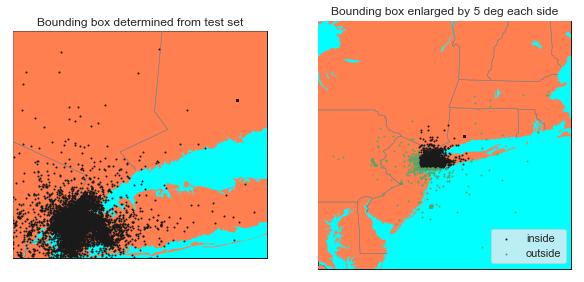

In [30]:
df_tmp = train_df.sample(frac=0.02, random_state=210)
print("df_tmp shape", df_tmp.shape)
inside_idx = is_pickup_inside(df_tmp, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX)

sns.set(font_scale=1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

bmap = create_nyc_map(ax[0], LON_MIN, LON_MAX, LAT_MIN, LAT_MAX)
bmap = plot_coor_on_map(bmap,  
                        df_tmp["pickup_longitude"].values,
                        df_tmp["pickup_latitude"].values,
                        marker="o", s=1, c="k", label=None)
ax[0].set_title("Bounding box determined from test set")

bmap = create_nyc_map(ax[1], LON_MIN-2.5, LON_MAX+2.5, LAT_MIN-2.5, LAT_MAX+2.5)
bmap = plot_coor_on_map(bmap,  
                        df_tmp.loc[inside_idx, "pickup_longitude"].values,
                        df_tmp.loc[inside_idx, "pickup_latitude"].values,
                        marker="o", s=1, c="k", label="inside")
bmap = plot_coor_on_map(bmap,  
                        df_tmp.loc[~inside_idx, "pickup_longitude"].values,
                        df_tmp.loc[~inside_idx, "pickup_latitude"].values,
                        marker="o", s=1, c="g", label="outside")
ax[1].set_title("Bounding box enlarged by 5 deg each side")
ax[1].legend()

del df_tmp

Vì bounding box sau khi increse 5$^o$ quá rộng nên ta sẽ chỉ increse 1$^o$ mỗi bên của bounding box so với tập test

In [31]:
inside_idx = is_inside(train_df, LON_MIN-0.5, LON_MAX+0.5, LAT_MIN-0.5, LAT_MAX+0.5)
print("Shape before dropping:", train_df.shape)
train_df = train_df[inside_idx]
print("Shape after dropping:", train_df.shape)

Shape before dropping: (55418281, 7)
Shape after dropping: (54254567, 7)


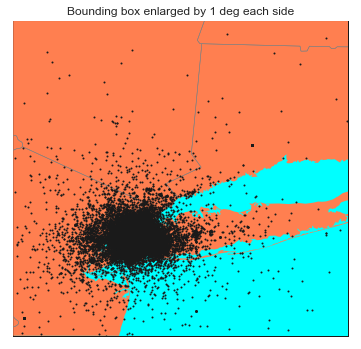

In [32]:
df_tmp = train_df.sample(frac=0.1, random_state=210)
sns.set(font_scale=1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

bmap = create_nyc_map(ax, LON_MIN-0.5, LON_MAX+0.5, LAT_MIN-0.5, LAT_MAX+0.5)
bmap = plot_coor_on_map(bmap,  
                        df_tmp["pickup_longitude"].values,
                        df_tmp["pickup_latitude"].values,
                        marker="o", s=1, c="k", label=None)
ax.set_title("Bounding box enlarged by 1 deg each side")

del df_tmp

Ta thấy có khá nhiều điểm rơi xuống nước. Ta thử kiểm tra xem các điểm của tập test có xảy ra điều này hay không.

Text(0.5,1,'Pickup coordinates of test set')

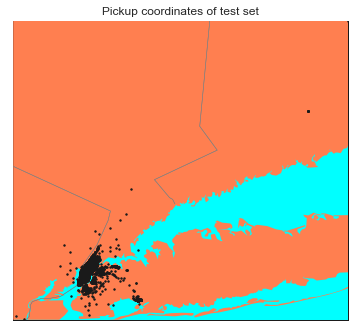

In [33]:
sns.set(font_scale=1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

bmap = create_nyc_map(ax, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX)
bmap = plot_coor_on_map(bmap,  
                        test_df["pickup_longitude"].values,
                        test_df["pickup_latitude"].values,
                        marker="o", s=2, c="k", label=None)
ax.set_title("Pickup coordinates of test set")

Tập test cũng có điểm rơi xuống nước nhưng rất ít. Ta thử kiểm tra xem `fare_amount` có ảnh hưởng đến toạ độ pickup và dropoff ở dưới nước hay không. 

In [34]:
def is_on_land(lons, lats):
    
    lon_min = np.min(lons) - 0.01
    lon_max = np.max(lons) + 0.01
    
    lat_min = np.min(lats) - 0.01
    lat_max = np.max(lats) + 0.01
    
    lon_0 = (lon_min + lon_max) / 2
    lat_0 = (lat_min + lat_max) / 2
    
    # projection="cyl" or projection="lcc"
    bm = Basemap(projection="cyl", resolution="h", 
                 llcrnrlat=lat_min, urcrnrlat=lat_max, 
                 llcrnrlon=lon_min, urcrnrlon=lon_max,
                 lon_0=lon_0, lat_0=lat_0)
    
    xpt, ypt = bm(lons, lats)
    vec_is_land = np.vectorize(bm.is_land)
    return vec_is_land(xpt, ypt)

def is_pickup_on_land(df):
    return is_on_land(df["pickup_longitude"].values, df["pickup_latitude"].values)

def is_dropoff_on_land(df):
    return is_on_land(df["dropoff_longitude"].values, df["dropoff_latitude"].values)

def is_both_pickup_or_dropoff_on_land(df):
    return is_pickup_on_land(df) & is_dropoff_on_land(df)

Hàm `is_both_pickup_or_dropoff_on_land` chạy rất tốn thời gian. Do đó, ta chỉ chạy 2% của tập train

In [35]:
create_csv = False

if create_csv:
    train_df_small = train_df.sample(frac=0.02, random_state=210)
    train_df_small["on_land"] = is_both_pickup_or_dropoff_on_land(train_df_small)
    train_df_small.to_csv(os.path.join(PROC_DIR, "train_df_small.csv"))
    print(train_df_small.shape)
    
else:
    train_df_small = pd.read_csv(os.path.join(PROC_DIR, "train_df_small.csv"))
    print(train_df_small.shape)

(1085091, 9)


In [36]:
print("There are %0.3f%% of points on water." % ((1 - train_df_small["on_land"].mean())*100) )

There are 0.338% of points on water.


Text(0.5,1,'On Water')

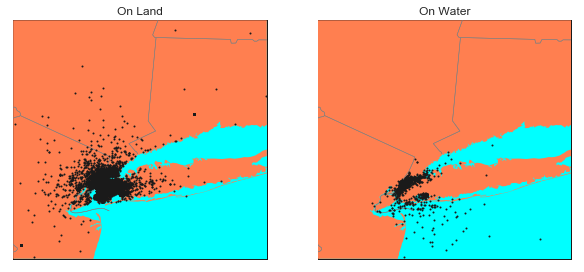

In [37]:
on_land = train_df_small["on_land"]
on_water = ~on_land

sns.set(font_scale=1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

bmap = create_nyc_map(ax[0], LON_MIN-0.5, LON_MAX+0.5, LAT_MIN-0.5, LAT_MAX+0.5)
bmap = plot_coor_on_map(bmap,  
                        train_df_small.loc[on_land, "pickup_longitude"].values,
                        train_df_small.loc[on_land, "pickup_latitude"].values,
                        marker="o", s=1, c="k", label=None)
ax[0].set_title("On Land")

bmap = create_nyc_map(ax[1], LON_MIN-0.5, LON_MAX+0.5, LAT_MIN-0.5, LAT_MAX+0.5)
bmap = plot_coor_on_map(bmap,  
                        train_df_small.loc[on_water, "pickup_longitude"].values,
                        train_df_small.loc[on_water, "pickup_latitude"].values,
                        marker="o", s=1, c="k", label=None)
ax[1].set_title("On Water")

Phân bố `fare_amount` của những chuyến taxi trên bờ và dưới nước

Text(0,0.5,'Density')

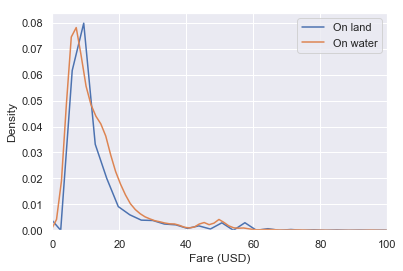

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.kdeplot(train_df_small.loc[train_df_small["on_land"], "fare_amount"], ax=ax, label="On land")
sns.kdeplot(train_df_small.loc[~train_df_small["on_land"], "fare_amount"], ax=ax, label="On water")
ax.set_xlim([0, 100])
ax.set_xlabel("Fare (USD)")
ax.set_ylabel("Density")

Nhìn vào hình vẽ, ta thấy phân bố giá taxi không ảnh hưởng bởi điểm pickup hoặc dropoff ở trên bờ hy dưới nước.

## Tính khoảng cách địa lý giữa 2 điểm pickup và dropoff
Link tham khảo:

https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula

In [39]:
# return distance in kilometer
def distance(lon1, lat1, lon2, lat2):
    if isinstance(lon1, pd.Series):
        lon1 = lon1.values
    
    if isinstance(lat1, pd.Series):
        lat1 = lat1.values
        
    if isinstance(lon2, pd.Series):
        lon2 = lon2.values
    
    if isinstance(lat2, pd.Series):
        lat2 = lat2.values
        
    # use more precise floating numbers
    if isinstance(lon1, np.ndarray):
        lon1 = np.asarray(lon1, dtype=np.float64)
    
    if isinstance(lat1, np.ndarray):
        lat1 = np.asarray(lat1, dtype=np.float64)
        
    if isinstance(lon2, np.ndarray):
        lon2 = np.asarray(lon2, dtype=np.float64)
    
    if isinstance(lat2, np.ndarray):
        lat2 = np.asarray(lat2, dtype=np.float64)
        
    lon1_rad = np.radians(lon1)
    lat1_rad = np.radians(lat1)
    lon2_rad = np.radians(lon2)
    lat2_rad = np.radians(lat2)
    
    a = 0.5 - 0.5*np.cos(lat2_rad - lat1_rad) + np.cos(lat1_rad)*np.cos(lat2_rad)*(1 - np.cos(lon2_rad - lon1_rad))*0.5
    return 12742 * np.arcsin(np.sqrt(a))

def add_distance_col(df):
    df["distance"] = distance(df["pickup_longitude"], df["pickup_latitude"],
                              df["dropoff_longitude"], df["dropoff_latitude"])
    df["distance"] = df["distance"].astype(np.float32)
    return df

In [40]:
train_df_small = add_distance_col(train_df_small)

Biểu đồ phân bố khoảng cách của các chuyến taxi trên bờ và dưới nước

Text(0,0.5,'Density')

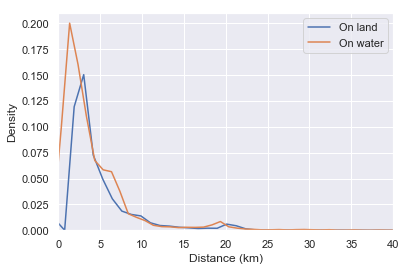

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.kdeplot(train_df_small.loc[train_df_small["on_land"], "distance"], ax=ax, label="On land")
sns.kdeplot(train_df_small.loc[~train_df_small["on_land"], "distance"], ax=ax, label="On water")
ax.set_xlim([0, 40])
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Density")

Nhìn vào hình, ta thấy phân bố khoảng cách của các chuyến đi trên bờ và dưới nước cũng không mấy khác biệt. Và cũng chỉ khoảng 0.3% các chuyến taxi có điểm pickup hoặc dropoff ở dưới nước
The distributions don't look that much different. Thêm vào đó, việc loại bỏ các điểm này tốn khá nhiều thời gian chạy máy tính nên ta quyết định để chúng trong tập train. 

In [42]:
del train_df_small

## Clean up number of passenger

In [43]:
print("min", train_df["passenger_count"].min())
print("max", train_df["passenger_count"].max())

min 0
max 208


In [44]:
for c in [5, 6, 7, 10, 20, 50, 100]:
    print("Number of rows with passenger_count greater than %d is %d" %(c, (train_df["passenger_count"] > c).sum()))

Number of rows with passenger_count greater than 5 is 1150268
Number of rows with passenger_count greater than 6 is 65
Number of rows with passenger_count greater than 7 is 52
Number of rows with passenger_count greater than 10 is 24
Number of rows with passenger_count greater than 20 is 24
Number of rows with passenger_count greater than 50 is 24
Number of rows with passenger_count greater than 100 is 24


Ta loại bỏ những hàng có `passenger_count` lớn hơn 6.

In [45]:
print("shape before dropping", train_df.shape)
train_df = train_df[train_df["passenger_count"] <= 6]
print("shape after dropping", train_df.shape)

shape before dropping (54254567, 7)
shape after dropping (54254502, 7)


[Text(0,0,'0'),
 Text(0,0,'1'),
 Text(0,0,'2'),
 Text(0,0,'3'),
 Text(0,0,'4'),
 Text(0,0,'5'),
 Text(0,0,'6')]

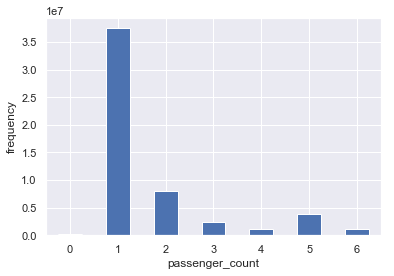

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
df_tmp = train_df["passenger_count"].value_counts().sort_index()
df_tmp.plot(kind="bar", ax=ax)

ax.set_xlabel("passenger_count")
ax.set_ylabel("frequency")

xticklabels = df_tmp.index.to_list()
ax.set_xticklabels(xticklabels, rotation=0)

Kiểm tra mối liên hệ giữa `passenger_count` và `fare_amount`

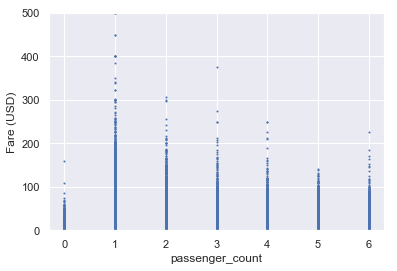

In [47]:
df_tmp = train_df.sample(frac=0.1, random_state=210)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

ax.scatter(df_tmp["passenger_count"], df_tmp["fare_amount"], s=1)
ax.set_ylim([0, 500])
ax.set_xlabel("passenger_count")
ax.set_ylabel("Fare (USD)")

del df_tmp

## Relationship between distance and fare

In [48]:
train_df = add_distance_col(train_df)

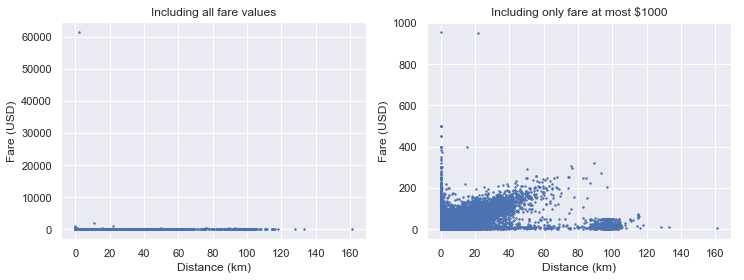

In [49]:
df_tmp = train_df.sample(frac=0.1, random_state=210)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax[0].scatter(df_tmp["distance"], df_tmp["fare_amount"], s=2)
ax[0].set_xlabel("Distance (km)")
ax[0].set_ylabel("Fare (USD)")
ax[0].set_title("Including all fare values")

df_tmp = df_tmp[df_tmp["fare_amount"] <= 1000]
ax[1].scatter(df_tmp["distance"], df_tmp["fare_amount"], s=2)
ax[1].set_xlabel("Distance (km)")
ax[1].set_ylabel("Fare (USD)")
ax[1].set_title("Including only fare at most $1000")

del df_tmp

In [50]:
print("Number of points with fare_amount greater than $500 is %d" % (train_df["fare_amount"] > 500).sum())

Number of points with fare_amount greater than $500 is 21


Vì số lượng dòng có `fare_amount` lớn hơn $500 rất ít nên ta quyết định drop chúng khỏi tập train

In [51]:
print("Shape before dropping", train_df.shape)
train_df = train_df[train_df["fare_amount"] <= 500]
print("Shape after dropping", train_df.shape)

Shape before dropping (54254502, 8)
Shape after dropping (54254481, 8)


Nhìn vào hình bên phải ta thấy có khá nhiều chuyến đi có distance=0 nhưng fare khác 0

In [52]:
print("There are %0.3f percent of rows having distance zero." % ((train_df["distance"] == 0).mean()*100))

There are 1.080 percent of rows having distance zero.


Let's compare fare distributions for the cases of zero and nonzero distances.

Text(0.5,1,'Zoom-in at small fare_amount')

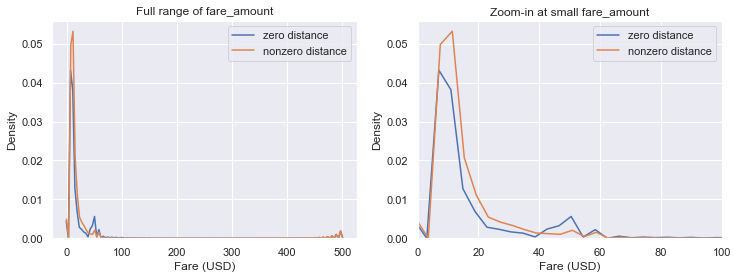

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.kdeplot(train_df.loc[train_df["distance"] == 0, "fare_amount"], ax=ax[0], label="zero distance")
sns.kdeplot(train_df.loc[train_df["distance"] > 0, "fare_amount"], ax=ax[0], label="nonzero distance")

ax[0].set_xlabel("Fare (USD)")
ax[0].set_ylabel("Density")
ax[0].set_title("Full range of fare_amount")

sns.kdeplot(train_df.loc[train_df["distance"] == 0, "fare_amount"], ax=ax[1], label="zero distance")
sns.kdeplot(train_df.loc[train_df["distance"] > 0, "fare_amount"], ax=ax[1], label="nonzero distance")

ax[1].set_xlim([0, 100])
ax[1].set_xlabel("Fare (USD)")
ax[1].set_ylabel("Density")
ax[1].set_title("Zoom-in at small fare_amount")

In [54]:
print("Median fare of non-zero distance trips: $%0.2f" % (
    train_df.loc[train_df["distance"] > 0, "fare_amount"].median()))
print("Median fare of zero distance trips: $%0.2f" % (
    train_df.loc[train_df["distance"] == 0, "fare_amount"].median()))

Median fare of non-zero distance trips: $8.50
Median fare of zero distance trips: $6.90


In [55]:
print("Min fare of zero distance trips: $%0.2f" % (
    train_df.loc[train_df["distance"] == 0, "fare_amount"].min()))
print("Max fare of zero distance trips: $%0.2f" % (
    train_df.loc[train_df["distance"] == 0, "fare_amount"].max()))

Min fare of zero distance trips: $0.00
Max fare of zero distance trips: $500.00


Các chuyến taxi có distance=0 có thể tương ứng với những chuyến bị khách hàng huỷ chuyến và bị driver tính phí chờ, hoặc khách hàng được discount hay coupons.

Do đó, ta sẽ tạo thêm 1 cột để phân biệt chuyến taxi là zero-distance.

In [56]:
print("Number of rows with zero fare_amount is %d" % (train_df["fare_amount"] == 0).sum() )

Number of rows with zero fare_amount is 1133


Let's zoom in the `fare_amount` versus `distance` scatter plot to see more clearly the relationship. 

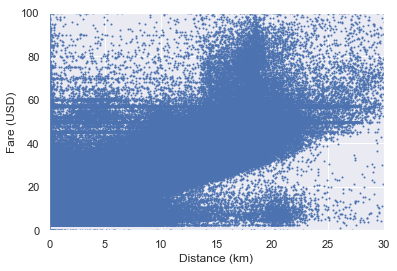

In [57]:
df_tmp = train_df.sample(frac=0.1, random_state=210)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

ax.scatter(df_tmp["distance"], df_tmp["fare_amount"], s=1)
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Fare (USD)")
ax.set_xlim(0, 30)
ax.set_ylim(0, 100)

del df_tmp

## Trips from or to airports

Nhìn vào hình scatter plot ở trên ta thấy có nhiều đường sọc ngang tương ứng với các chuyến taxi có giá cố định. Đó có thể là các chuyến đi có pickup hoặc dropoff từ sân bay.

Có 3 sân bay chính phục vụ cho New York city là **John F. Kennedy International Airport (JFK)**, **Newark Liberty International Airport (EWR)** and **LaGuardia Airport (LGA)**. Ta sẽ tạo thêm 1 cột `from_to_airport` trong tập `train` để phân biệt các chuyến taxi không liên qian tới sân bay (`No`) và những chuyến có liên quan đến sân bay là (`JFK`, `EWR` or `LGA`).

Một chuyến taxi là `from_to_airport` nếu điểm pickup và dropoff cách vị trí sân bay trong bán kính 3km. Việc xác định vị trí của 3 sân bay trên dựa vào:

https://tools.wmflabs.org/geohack/geohack.php?pagename=John_F._Kennedy_International_Airport&params=40_38_23_N_073_46_44_W_region:US-NY_type:airport

https://tools.wmflabs.org/geohack/geohack.php?pagename=LaGuardia_Airport&params=40_46_38.1_N_73_52_21.4_W_region:US-NY_type:airport

https://tools.wmflabs.org/geohack/geohack.php?pagename=Newark_Liberty_International_Airport&params=40_41_33_N_074_10_07_W_region:US-NJ_type:airport

In [58]:
# 40.639722, -73.778889
JFK_LON = -73.778889
JFK_LAT = 40.639722

# 40.6925, -74.168611
EWR_LON = -74.168611
EWR_LAT = 40.6925

# 40.77725, -73.872611
LGA_LON = -73.872611
LGA_LAT = 40.77725

def is_to_airport(df, airport_lon, airport_lat, thres=3):
    dist = distance(airport_lon, airport_lat, df["dropoff_longitude"], df["dropoff_latitude"])
    return dist < thres

def is_from_airport(df, airport_lon, airport_lat, thres=3.):
    dist = distance(airport_lon, airport_lat, df["pickup_longitude"], df["pickup_latitude"])
    return dist < thres

def mark_airport_trip(df, 
                      jfk_lon=JFK_LON, jfk_lat=JFK_LAT, 
                      ewr_lon=EWR_LON, ewr_lat=EWR_LAT,
                      lga_lon=LGA_LON, lga_lat=LGA_LAT):
    
    df["from_to_airport"] = "No"
    
    from_to_jfk = is_to_airport(df, jfk_lon, jfk_lat) | is_from_airport(df, jfk_lon, jfk_lat)
    df.loc[from_to_jfk, "from_to_airport"] = "JFK"
    
    from_to_ewr = is_to_airport(df, ewr_lon, ewr_lat) | is_from_airport(df, ewr_lon, ewr_lat)
    df.loc[from_to_ewr, "from_to_airport"] = "EWR"
    
    from_to_lga = is_to_airport(df, lga_lon, lga_lat) | is_from_airport(df, lga_lon, lga_lat)
    df.loc[from_to_lga, "from_to_airport"] = "LGA"
    
    return df

In [59]:
train_df = mark_airport_trip(train_df)

In [60]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,from_to_airport
0,4.5,2009-06-15 13:26:21-04:00,-73.844315,40.721317,-73.841614,40.712276,1,1.030742,No
1,16.9,2010-01-05 11:52:16-05:00,-74.016045,40.711304,-73.979271,40.782005,1,8.450001,No
2,5.7,2011-08-17 20:35:00-04:00,-73.982735,40.761269,-73.991241,40.750561,2,1.389632,No
3,7.7,2012-04-21 00:30:42-04:00,-73.987129,40.733143,-73.991570,40.758091,1,2.799211,No
4,5.3,2010-03-09 02:51:00-05:00,-73.968094,40.768009,-73.956657,40.783764,1,1.999081,No


In [61]:
train_df["from_to_airport"].value_counts()

No     51147364
LGA     1893208
JFK     1139636
EWR       74273
Name: from_to_airport, dtype: int64

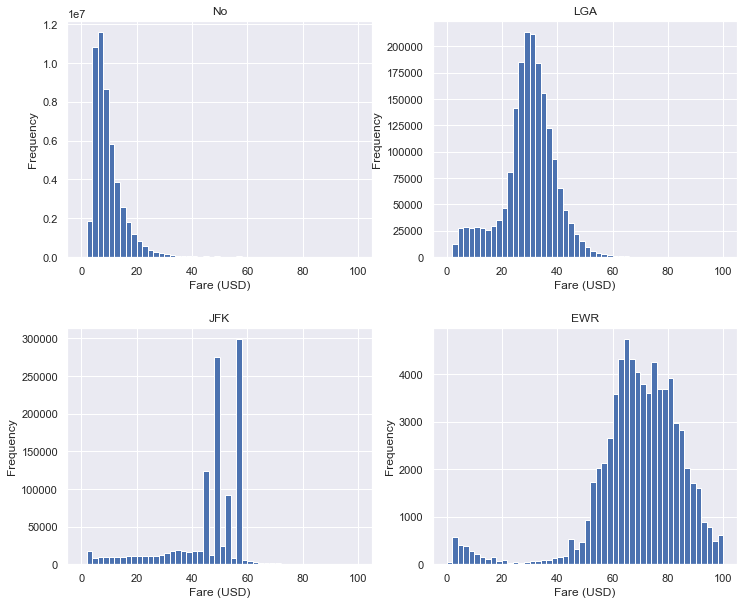

In [62]:
df_le_100 = train_df[train_df["fare_amount"] <= 100] # le == less than or equal to

airports = df_le_100["from_to_airport"].value_counts().index

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.3)
axes = axes.flatten()

for airp, ax in zip(airports, axes):
    df_le_100.loc[df_le_100["from_to_airport"] == airp, "fare_amount"].plot(kind="hist", bins=50, ax=ax)
    ax.set_xlabel("Fare (USD)")
    ax.set_title(airp)

del df_le_100

Nhìn vào hình trên ta thấy giá của các chuyến đi liên quan đến sân bay thường mắc hơn những chuyến thông thường. Và chỉ có những chuyến `from_to_airport` của sân bay `JFK` là có giá cố định rõ rệt

No     5114608
LGA     189582
JFK     113823
EWR       7435
Name: from_to_airport, dtype: int64


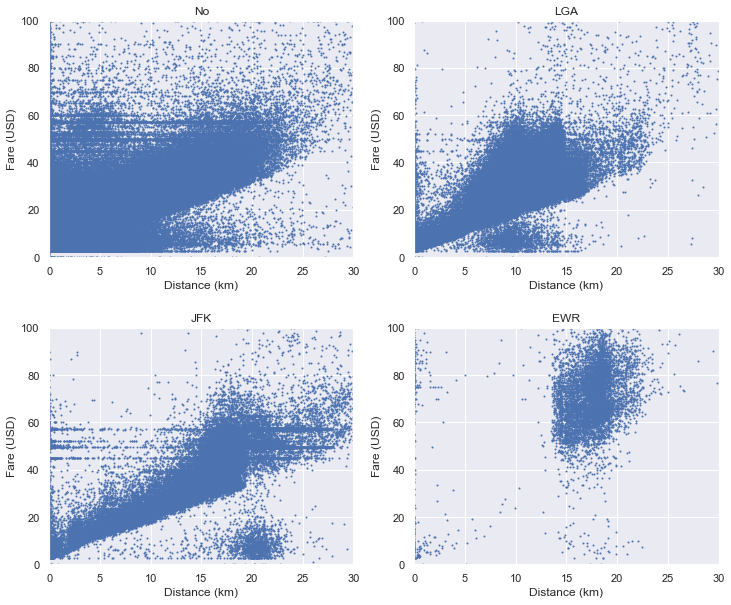

In [63]:
df_tmp = train_df.sample(frac=0.1, random_state=210)
print(df_tmp["from_to_airport"].value_counts())

airports = df_tmp["from_to_airport"].value_counts().index

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.3)
axes = axes.flatten()

for airp, ax in zip(airports, axes):
    ax.scatter(df_tmp.loc[df_tmp["from_to_airport"] == airp, "distance"],
               df_tmp.loc[df_tmp["from_to_airport"] == airp, "fare_amount"], 
               s=1)
    ax.set_xlabel("Distance (km)")
    ax.set_ylabel("Fare (USD)")
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 100)
    ax.set_title(airp)
    
del df_tmp

Nhìn vào hình ta thấy cũng có nhiều chuyến taxi có giá cố định nhưng ko liên quan đến sân bay.

## Pickup and dropoff locations relative the city center.

In [64]:
# New York City Coordinates from google
NYC_LON = -74.006
NYC_LAT = 40.7128

def add_pickup_to_center_dist_col(df, nyc_lon=NYC_LON, nyc_lat=NYC_LAT):
    df["pickup_to_center_dist"] = distance(nyc_lon, nyc_lat, 
                                           df["pickup_longitude"], df["pickup_latitude"])
    df["pickup_to_center_dist"] = df["pickup_to_center_dist"].astype(np.float32)
    return df


def add_dropoff_to_center_dist_col(df, nyc_lon=NYC_LON, nyc_lat=NYC_LAT):
    df["dropoff_to_center_dist"] = distance(nyc_lon, nyc_lat, 
                                            df["dropoff_longitude"], df["dropoff_latitude"])
    df["dropoff_to_center_dist"] = df["dropoff_to_center_dist"].astype(np.float32)
    return df

In [65]:
train_df = add_pickup_to_center_dist_col(train_df)
train_df = add_dropoff_to_center_dist_col(train_df)

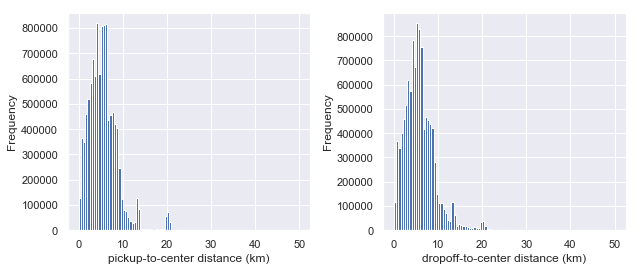

In [66]:
df_tmp = train_df[train_df["pickup_to_center_dist"] < 50].sample(frac=0.2, random_state=210)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.3)

df_tmp["pickup_to_center_dist"].plot(kind="hist", bins=100, ax=ax[0])
ax[0].set_xlabel("pickup-to-center distance (km)")
del df_tmp

df_tmp = train_df[train_df["dropoff_to_center_dist"] < 50].sample(frac=0.2, random_state=210)

df_tmp["dropoff_to_center_dist"].plot(kind="hist", bins=100, ax=ax[1])
ax[1].set_xlabel("dropoff-to-center distance (km)")
del df_tmp

The side peaks at about 15 and 20 km may be airports. Let's check that.

In [67]:
print("Distance from NYC center to JFK airport is %0.2f km" % distance(NYC_LON, NYC_LAT, JFK_LON, JFK_LAT))

print("Distance from NYC center to EWR airport is %0.2f km" % distance(NYC_LON, NYC_LAT, EWR_LON, EWR_LAT))

print("Distance from NYC center to LGA airport is %0.2f km" % distance(NYC_LON, NYC_LAT, LGA_LON, LGA_LAT))

Distance from NYC center to JFK airport is 20.80 km
Distance from NYC center to EWR airport is 13.89 km
Distance from NYC center to LGA airport is 13.33 km


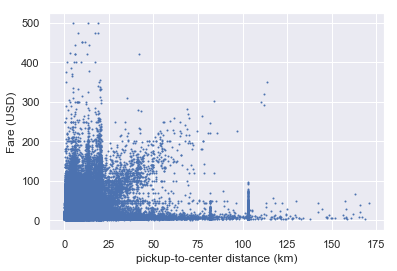

In [68]:
df_tmp = train_df.sample(frac=0.2, random_state=210)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

ax.scatter(df_tmp["pickup_to_center_dist"], df_tmp["fare_amount"], s=1)
ax.set_xlabel("pickup-to-center distance (km)")
ax.set_ylabel("Fare (USD)")
del df_tmp

Let's also define `fare_per_km`. 

distace có giá trị 0. Để tránh việc chia co 0, ta sẽ thay thế các zero distances bằng giá trị minimum của non-zero distances chia cho 10

In [69]:
def fare_per_km(df):
    nonzero_dist_min = df.loc[df["distance"] > 0, "distance"].min()
    zero_impute_val = nonzero_dist_min / 10.
    print("Impute zero distance by %0.5f km" % zero_impute_val)
    
    dist = df["distance"].copy()
    dist[dist == 0] = zero_impute_val
    
    return df["fare_amount"] / dist

In [70]:
train_df["fare_per_km"] = fare_per_km(train_df)

Impute zero distance by 0.00004 km


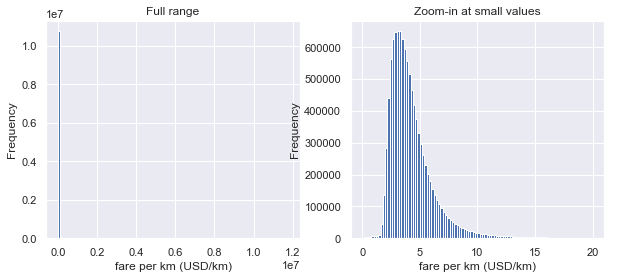

In [71]:
df_tmp = train_df.sample(frac=0.2, random_state=210)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

df_tmp["fare_per_km"].plot(kind="hist", bins=100, ax=ax[0])
ax[0].set_xlabel("fare per km (USD/km)")
ax[0].set_title("Full range")
del df_tmp

df_tmp = train_df[train_df["fare_per_km"] < 20].sample(frac=0.2, random_state=210)
df_tmp["fare_per_km"].plot(kind="hist", bins=100, ax=ax[1])
ax[1].set_xlabel("fare per km (USD/km)")
ax[1].set_title("Zoom-in at small values")
del df_tmp

Let's see how pickup or dropoff location affects `fare_per_km`.

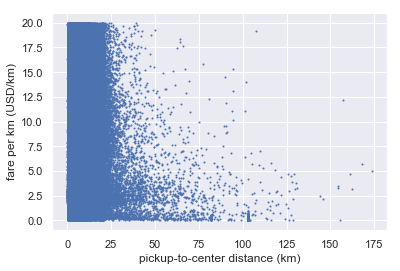

In [72]:
df_tmp = train_df[train_df["fare_per_km"] < 20].sample(frac=0.2, random_state=210)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

ax.scatter(df_tmp["pickup_to_center_dist"], df_tmp["fare_per_km"], s=1)
ax.set_xlabel("pickup-to-center distance (km)")
ax.set_ylabel("fare per km (USD/km)")
del df_tmp

Có vẻ như khi `pickup_to_center_dist` < 25km (gần trung tâm) thì `fare_per_km` không phụ thuộc vào vị trí pickup của passenger. Còn khi xa trung tâm thì `fare_per_km` giảm dần

## Travel direction
Kiểm tra xem `travel direction` có ảnh hưởng tới giá cước của taxi hay không.

Direction được xác định bởi góc của vector pointing from pickup to dropoff với the horizontal x axis

In [73]:
def direction(lons_1, lats_1, lons_2, lats_2):
    bm = Basemap()
    
    x1, y1 = bm(lons_1, lats_1)
    x2, y2 = bm(lons_2, lats_2)
    
    dx = x2 - x1
    dy = y2 - y1
    
    hypotenuse = np.sqrt(dx*dx + dy*dy)
    
    pos_dx = dx >= 0
    neg_dx = dx < 0
    
    pos_dy = dy >= 0
    neg_dy = dy < 0
    
    neg_dx_and_pos_dy = neg_dx & pos_dy
    neg_dx_and_neg_dy = neg_dx & neg_dy
    
    direc = np.zeros(len(dx))
    
    direc[pos_dx] = np.arcsin(dy[pos_dx] / hypotenuse[pos_dx])
    
    direc[neg_dx_and_pos_dy] = np.pi - np.arcsin(dy[neg_dx_and_pos_dy] / hypotenuse[neg_dx_and_pos_dy])
    
    direc[neg_dx_and_neg_dy] = -np.pi - np.arcsin(dy[neg_dx_and_neg_dy] / hypotenuse[neg_dx_and_neg_dy])
    
    direc = 180 / np.pi * direc
    return direc

def add_direction_col(df):
    df["direction"] = direction(df["pickup_longitude"], df["pickup_latitude"],
                                df["dropoff_longitude"], df["dropoff_latitude"])
    df["direction"] = df["direction"].astype(np.float32)
    
    return df

In [74]:
train_df = add_direction_col(train_df)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arcsin


In [75]:
print("Number of na %d" % train_df["direction"].isna().sum())
print("Percent of na %0.5f" % (train_df["direction"].isna().mean()*100))

Number of na 586042
Percent of na 1.08017


Giá trị NaN là do cạnh huyền (hypotenuse) bằng 0

In [76]:
print("Number of zero distances %d" %(train_df["distance"] == 0).sum())

Number of zero distances 586042


Ta thay thế các giá trị `NaN` của `direction` bằng median.

In [77]:
def impute_nan_direction(df):
    df.loc[df["direction"].isna(), "direction"] = df["direction"].median()
    return df

In [78]:
train_df = impute_nan_direction(train_df)

In [79]:
train_df["direction"].isna().sum()

0

Text(0.5,1,'Histogram of direction angle')

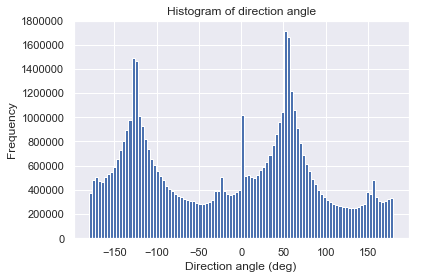

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

train_df["direction"].plot(kind="hist", bins=100, ax=ax)
ax.set_xlabel("Direction angle (deg)")
ax.set_title("Histogram of direction angle")

Những chuyến taxi theo hướng Đông-Bắc (Northeast) (khoảng 60$^o$) <--> Tây-Nam (Southwest) (-140$^o$) chiếm đa số. Đây cũng là hướng của hầu hết các con đường ở NYC. 

Let's look at the map zoom-in around Manhattan.

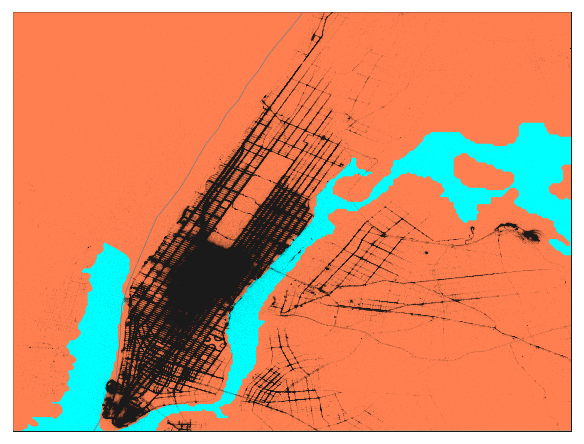

In [81]:
# -74.05, -73.85, 40.7, 40.9
lon_min = -74.05
lon_max = -73.85
lat_min = 40.7
lat_max = 40.85

df_tmp = train_df.sample(frac=0.2, random_state=210)

sns.set(font_scale=1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

bmap = create_nyc_map(ax, lon_min, lon_max, lat_min, lat_max, resolution="f")
bmap = plot_coor_on_map(bmap,  
                        df_tmp["pickup_longitude"].values,
                        df_tmp["pickup_latitude"].values,
                        marker="o", s=0.001, c="k", alpha=0.3, label=None)
del df_tmp

Let's look at how `fare_amount` depends on `direction`.

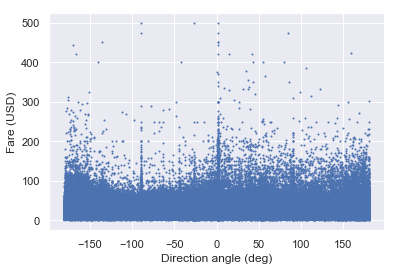

In [82]:
df_tmp = train_df.sample(frac=0.2, random_state=210)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

ax.scatter(df_tmp["direction"], df_tmp["fare_amount"], s=1)
ax.set_xlabel("Direction angle (deg)")
ax.set_ylabel("Fare (USD)")
del df_tmp

Let's bin the `direction` angle and calculate median `fare_amount` for each bin.

Text(0,0.5,'Median fare (USD)')

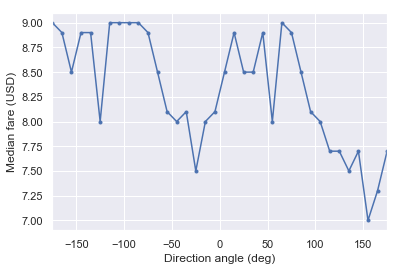

In [83]:
bin_edges = np.linspace(-180, 180, 37)
bin_cent = (bin_edges[:-1] + bin_edges[1:])/2

direc_cut = pd.cut(train_df["direction"], bin_edges)
median_fare_by_direc = train_df.groupby(direc_cut)["fare_amount"].median()
median_fare_by_direc.index = bin_cent

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
median_fare_by_direc.plot(kind="line", ax=ax, linestyle="-", marker=".")
ax.set_xlabel("Direction angle (deg)")
ax.set_ylabel("Median fare (USD)")

## Cleaning and exploring temporal data

Let's create columns `year`, `month`, `weekday` and `hour` from column `pickup_datetime`

In [84]:
t = train_df["pickup_datetime"]

In [85]:
t.apply(lambda t: t.weekday)[:10]

0    0
1    1
2    2
3    5
4    1
5    3
6    1
7    2
8    0
9    1
Name: pickup_datetime, dtype: int64

In [86]:
def ad_time_cols(df):
    df["year"] = df["pickup_datetime"].apply(lambda t: t.year).astype(np.int32)
    df["month"] = df["pickup_datetime"].apply(lambda t: t.month).astype(np.uint8)
    df["weekday"] = df["pickup_datetime"].apply(lambda t: t.weekday).astype(np.uint8)
    df["hour"] = df["pickup_datetime"].apply(lambda t: t.hour).astype(np.uint8)
    return df

In [87]:
train_df = ad_time_cols(train_df)

In [88]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,from_to_airport,pickup_to_center_dist,dropoff_to_center_dist,fare_per_km,direction,year,month,weekday,hour
0,4.5,2009-06-15 13:26:21-04:00,-73.844315,40.721317,-73.841614,40.712276,1,1.030742,No,13.659573,13.855385,4.365786,-73.367325,2009,6,0,13
1,16.9,2010-01-05 11:52:16-05:00,-74.016045,40.711304,-73.979271,40.782005,1,8.450001,No,0.862809,8.017940,2.000000,62.519924,2010,1,1,11
2,5.7,2011-08-17 20:35:00-04:00,-73.982735,40.761269,-73.991241,40.750561,2,1.389632,No,5.734865,4.379088,4.101805,-128.465118,2011,8,2,20
3,7.7,2012-04-21 00:30:42-04:00,-73.987129,40.733143,-73.991570,40.758091,1,2.799211,No,2.765087,5.180817,2.750776,100.091927,2012,4,5,0
4,5.3,2010-03-09 02:51:00-05:00,-73.968094,40.768009,-73.956657,40.783764,1,1.999081,No,6.919971,8.918654,2.651218,54.023800,2010,3,1,2


In [89]:
print(train_df["year"].isna().sum())
print(train_df["year"].min())
print(train_df["year"].max())

0
2008
2015


In [90]:
print(train_df["month"].isna().sum())
print(train_df["month"].min())
print(train_df["month"].max())

0
1
12


In [91]:
print(train_df["weekday"].isna().sum())
print(train_df["weekday"].min())
print(train_df["weekday"].max())

0
0
6


In [92]:
print(train_df["hour"].isna().sum())
print(train_df["hour"].min())
print(train_df["hour"].max())

0
0
23


## Taxi usage and fare by year, month, weekday and hour.

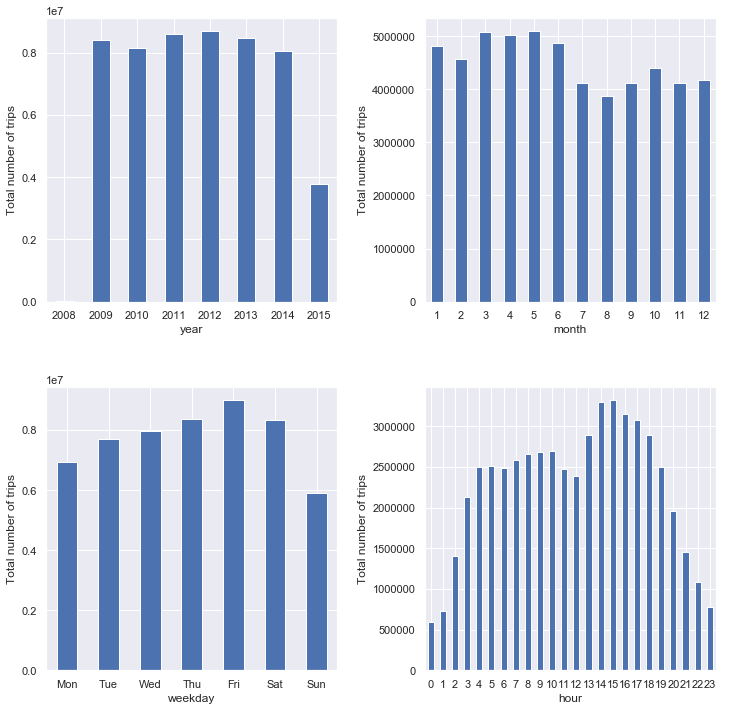

In [93]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.flatten()

for ax, t in zip(axes, ["year", "month", "weekday", "hour"]):
    agg = train_df.groupby(t)["fare_amount"].agg("count")
    agg.plot(kind="bar", ax=ax)
    ax.set_ylabel("Total number of trips")
    
    xticklabels = agg.index.to_list()
    if t == "weekday":
        xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    ax.set_xticklabels(xticklabels, rotation=0)

Data ko được thu thập đầy đủ cho năm 2008 và 2015. Nên ta remove năm 2008 và 2015 và tính lại thống kê tổng số chuyến taxi.

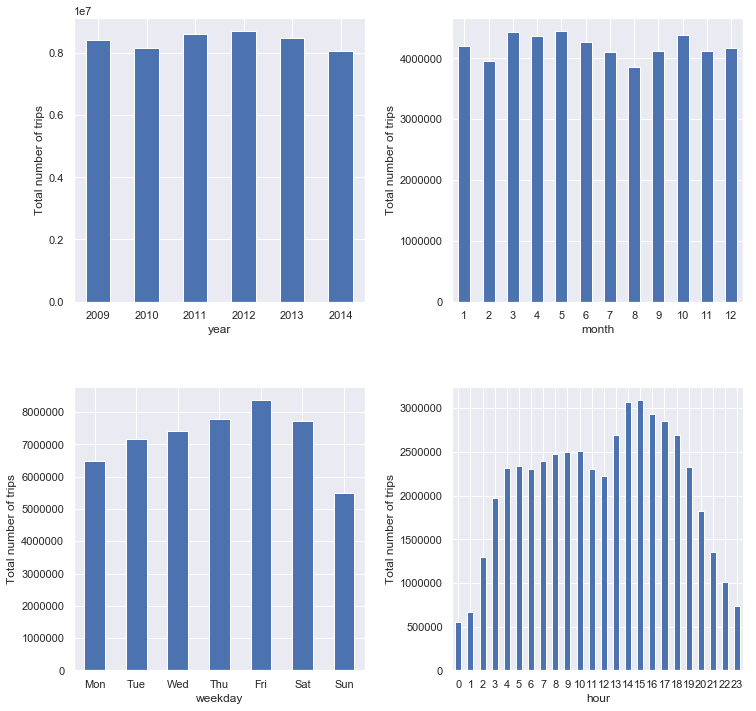

In [95]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.flatten()

df_tmp = train_df[train_df["year"].between(2009, 2014)]

for ax, t in zip(axes, ["year", "month", "weekday", "hour"]):
    agg = df_tmp.groupby(t)["fare_amount"].agg("count")
    agg.plot(kind="bar", ax=ax)
    ax.set_ylabel("Total number of trips")
    
    xticklabels = agg.index.to_list()
    if t == "weekday":
        xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    ax.set_xticklabels(xticklabels, rotation=0)

del df_tmp

Nhìn vào hình trên ta thấy: trong một năm thì số lượng chuyến taxi giảm vào tháng 8 (mùa hè). Và trong một tuần, thì số lượng chuyến taxi giảm vào chủ nhật. Còn trong 1 ngày thì số lượng chuyến taxi tăng vào giờ cao điểm (từ 2pm đến 6pm)

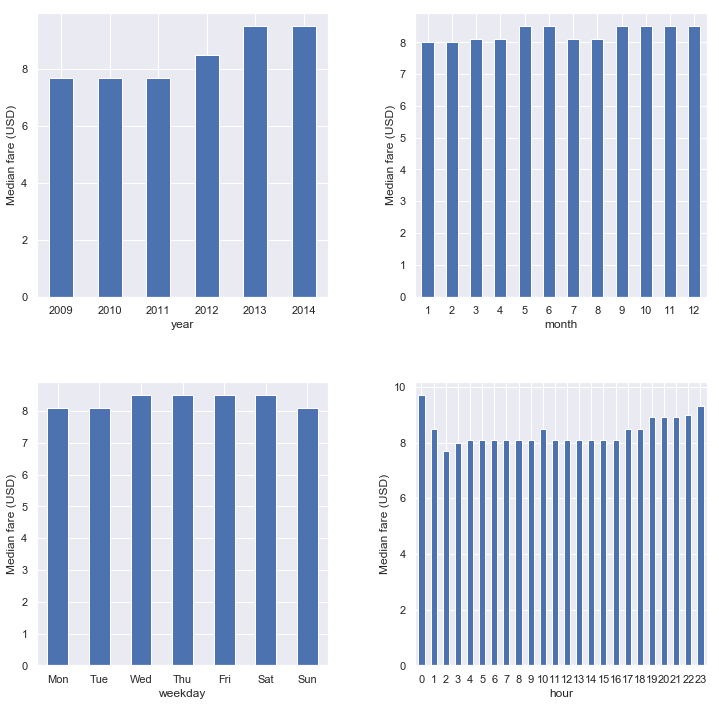

In [96]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.flatten()

df_tmp = train_df[train_df["year"].between(2009, 2014)]

for ax, t in zip(axes, ["year", "month", "weekday", "hour"]):
    agg = df_tmp.groupby(t)["fare_amount"].agg("median")
    agg.plot(kind="bar", ax=ax)
    ax.set_ylabel("Median fare (USD)")
    
    xticklabels = agg.index.to_list()
    if t == "weekday":
        xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    ax.set_xticklabels(xticklabels, rotation=0)

del df_tmp

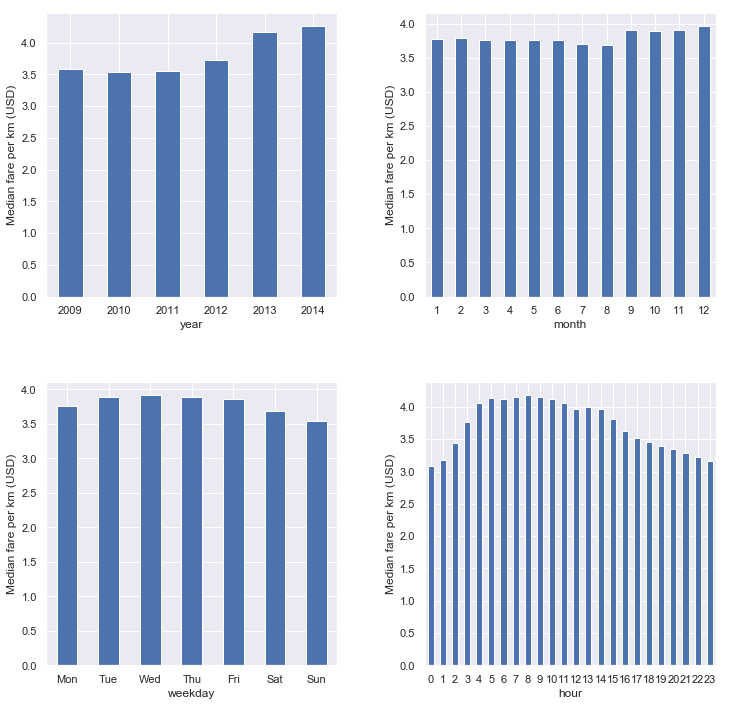

In [97]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
axes = axes.flatten()

df_tmp = train_df[train_df["year"].between(2009, 2014)]

for ax, t in zip(axes, ["year", "month", "weekday", "hour"]):
    agg = df_tmp.groupby(t)["fare_per_km"].agg("median")
    agg.plot(kind="bar", ax=ax)
    ax.set_ylabel("Median fare per km (USD)")
    
    xticklabels = agg.index.to_list()
    if t == "weekday":
        xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    ax.set_xticklabels(xticklabels, rotation=0)

Giá taxi tăng dần theo năm, giá taxi giảm vào cuối tuần & mùa hè (tháng 7, tháng 8)

## Save to csv

We remove columns generated during EDA before saving to csv file.

In [98]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance',
       'from_to_airport', 'pickup_to_center_dist', 'dropoff_to_center_dist',
       'fare_per_km', 'direction', 'year', 'month', 'weekday', 'hour'],
      dtype='object')

In [99]:
rm_cols = train_df.columns.to_list()[7:]
rm_cols 

['distance',
 'from_to_airport',
 'pickup_to_center_dist',
 'dropoff_to_center_dist',
 'fare_per_km',
 'direction',
 'year',
 'month',
 'weekday',
 'hour']

In [100]:
train_df.drop(rm_cols, axis=1, inplace=True)
train_df.shape

(54254481, 7)

In [101]:
save_csv = False

if save_csv:
    train_df.to_csv(os.path.join(PROC_DIR, "train_df.csv"), index=False)

In [102]:
save_csv = False

if save_csv:
    test_df.to_csv(os.path.join(PROC_DIR, "test_df.csv"), index=False)

In [103]:
del train_df
del test_df